In [6]:
import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from train import train
from models import Transformer, Low_rank, AoT
from utils import generate_data, entropy, power_unif_law
from tqdm import tqdm

100%|██████████| 4000/4000 [00:11<00:00, 354.63it/s]


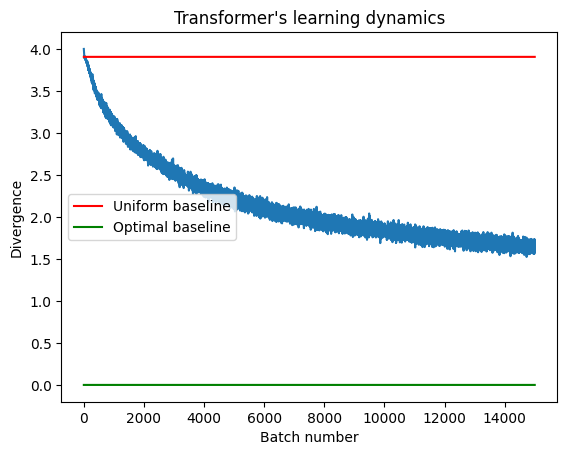

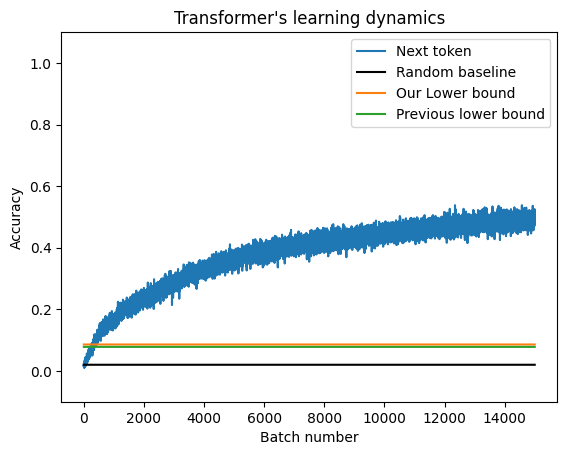

In [14]:
"""Training Transformer."""

# Transformer parameters.
N = 50
d = 10
nb_layers = 1
width = 0
depth = 0
para = 21
d_head = 8
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[N, N, 1]
t.manual_seed(2222)
pi = power_unif_law(alphas, nb_tokens, N)

# Learning parameters for the Transformer.
batch_size=2**10
num_batch=15000
lr=1e-3
Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)

# Training the Transformer.
model = Transformer(d, N, nb_layers, width, depth, para, d_head, nb_head, context_window, pi)
Dict = train(model, Data, lr=lr, next_token=True)
plt.plot(Dict['Loss'])

# Upper bound: we compute the divergence with the uniform predictor.
ent=entropy(pi)
plt.plot([np.log(N)-ent for _ in Dict['Loss']], label='Uniform baseline', color='red')

# Learning parameters for the sequence encoder.
low_batch_size=2**10
low_num_batch=4000
low_lr=1e-3

# Lower bound: we compute the best Sequence encoder, the diverge of which sets the attainable lower bound.
model_low = Low_rank(d, N, context_window, pi)
Data = generate_data(low_batch_size, low_num_batch, pi, context_window)
dict_low = train(model_low, Data, lr=low_lr)
best_loss = sum(dict_low['Loss'][-101:-1])/100
plt.plot([best_loss for _ in Dict['Loss']], label='Optimal baseline', color='green')

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Divergence")
plt.title("Transformer's learning dynamics")
plt.show()

# We plot the accuracy of the Transformer, the accuracy of the random predictor, 
# and the lower bound from are paper as well as the previous sota bound (in accuracy, not in worst-case).
plt.plot(Dict['Acc'], label=f'Next token')
plt.plot([1/N for _ in Dict['Acc']], color='black', label='Random baseline')
plt.plot([1/N+(1-1/N)*para*d_head/(N**(n_gram-1)) for _ in Dict['Acc']], label='Our Lower bound')
plt.plot([1/N+(1-1/N)*(para*(d_head-1)+1)/(N**(n_gram-1)) for _ in Dict['Acc']], label='Previous lower bound')

plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Accuracy")
plt.ylim(top=1+0.1, bottom=0-0.1)
plt.title("Transformer's learning dynamics")
plt.show()

In [16]:
"""Scaling laws for the Memorization Capacity of an AoT."""

# Choice of the experiment: 
# - 1 for the case d=d_head, 
# - 2 for the case d fixed, 
# - 3 for the case d_head fixed,
exp_number = 2
if exp_number == 1:
    parameter_list = [(50, d, d, 31+1, 1, 5) for d in range(3, 13+1)]
elif exp_number == 2:
    parameter_list = [(50, 10, d_head, 21+1, 5, 4) for d_head in [10, 11, 12, 13, 15, 16]]
elif exp_number == 3:
    parameter_list = [(50, d, 10, 21+1, 5, 4) for d in range(5, 15+1, 2)]

# Model parameters.
nb_layers = 1
nb_head = 1
n_gram = 3
context_window = n_gram

# Distribution parameters.
alphas = [1, 1, 1]
nb_tokens=[100, 100, 1]

# Training parameters.
batch_size=2**10
num_batch=10000
lr=1e-3

repetition = 2

t.manual_seed(2222)
for i, (N, d, d_head, max_para, min_para, step) in enumerate(parameter_list):
    pi = power_unif_law(alphas, nb_tokens, N)
    Data = generate_data(batch_size=batch_size, num_batch=num_batch, pi=pi, context_window=context_window)
    
    mean_accuracy = []
    para_list = []
    N_list = []
    d_list = []
    d_head_list = []

    for para in tqdm(range(min_para, max_para+1, step)):
        accuracy = 0

        for _ in range(repetition):
            model = AoT(d, N, nb_layers, para, d_head, nb_head, context_window, pi)
            dict = train(model, Data, lr=lr, next_token=True)
            acc = sum(dict['Acc'][-101:-1])/100
            
            accuracy += acc

        mean_accuracy.append(accuracy/repetition)
        para_list.append(para)
        N_list.append(N)
        d_list.append(d)
        d_head_list.append(d_head)

    results = {
        'acc': mean_accuracy,
        'para': para_list,
        'N': N_list,
        'd': d_list,
        'd_head': d_head_list,
    }

    # We save the results as a dataframe.
    data = pd.DataFrame(results)
    data.to_csv(f'Scaling laws/Exp_{6+i}_{exp_number}.csv', index=False)

100%|██████████| 10000/10000 [02:03<00:00, 81.21it/s]


In [ ]:
"""Comparison AoT and MLP"""